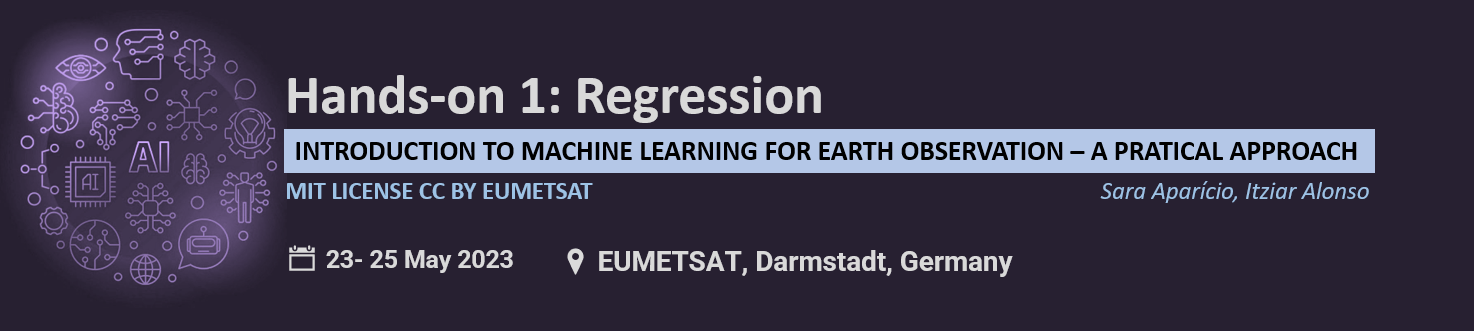

 ## <span style="color:red"># PARTICIPANT'S VERSION: Do not edit. Make a copy and rename it.</span> 

## Goal: 
### Using **NO2, H20, etc** as a predictor of **O3 concentrations** (Sentinel-5P products as source).

#### Machine learning workflow:
- **Step 0:** Import all libraries (overview of libraries in this notebook)
- **Step 1:**  Training data loading and preparation
    - Definition of features (X) and target (y) variables
    - Training and Test data 
- **Step 2:** Create the model
- **Step 3:** Model fitting 
- **Step 4:** Make predictions on the test data
- **Step 5:** Evaluate model's performance
- **Step 6:** Go further! 
- **Step 7/Optional:** Revisiting Random Forests 


## Step 0: Import all libraries
Need the following packages:
- **Scikit-learn** - (also known as **sklearn**) is a free software machine learning library for the Python programming language, containing many algorithms > you can grab different models (e.g.: SVM, RF).
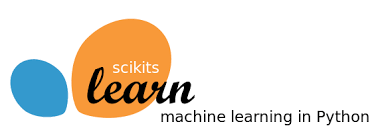
- **GDAL** - translator library for raster and vector geospatial data
- **Numpy** - provides a simple and powerful data strcuture: n-dimensioanl array
- **Matplotlib** - visualization 
- **Pandas** - offers data structures and operations for manipulating numerical tables and time series. 

In [3]:
# Importing all the libraries
import numpy as np
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
from sklearn import cluster

import pandas as pd

from pandas import DataFrame
from pandas import concat

#Tell GDAL to throw Python exceptions, and register all drivers
#gdal.UseExceptions()
#gdal.AllRegister()

### Step 1: Training data loading and preparation
Most of the time, we can't simply feed raw data into a model and have it return an answer. Normally some modification is needed to put our data into **machine-understandble** terms - or as it's is also called **AI-ready data**, this includes loading the data, defining the target (what we want to classify or in this case **predict**) and the features, i.e. the other variables that will act as predictors, it also requires preprocess the data and structure it a way suitable for the model.


Some considerations:
- The python library **pandas** is a common tool to manipulate the data relying on the structure known as **dataframe**, which works like an excel spreadsheet with rows and columns. 
- **Missing data** can impact analysis as can incorrect data or outliers. Ensuring a clean dataframe is an essential step.
- Some ML algortithms (like SVM) require that training data is normalized first.

For this exercice we will have two datasets containing the same variables, but different AOI:
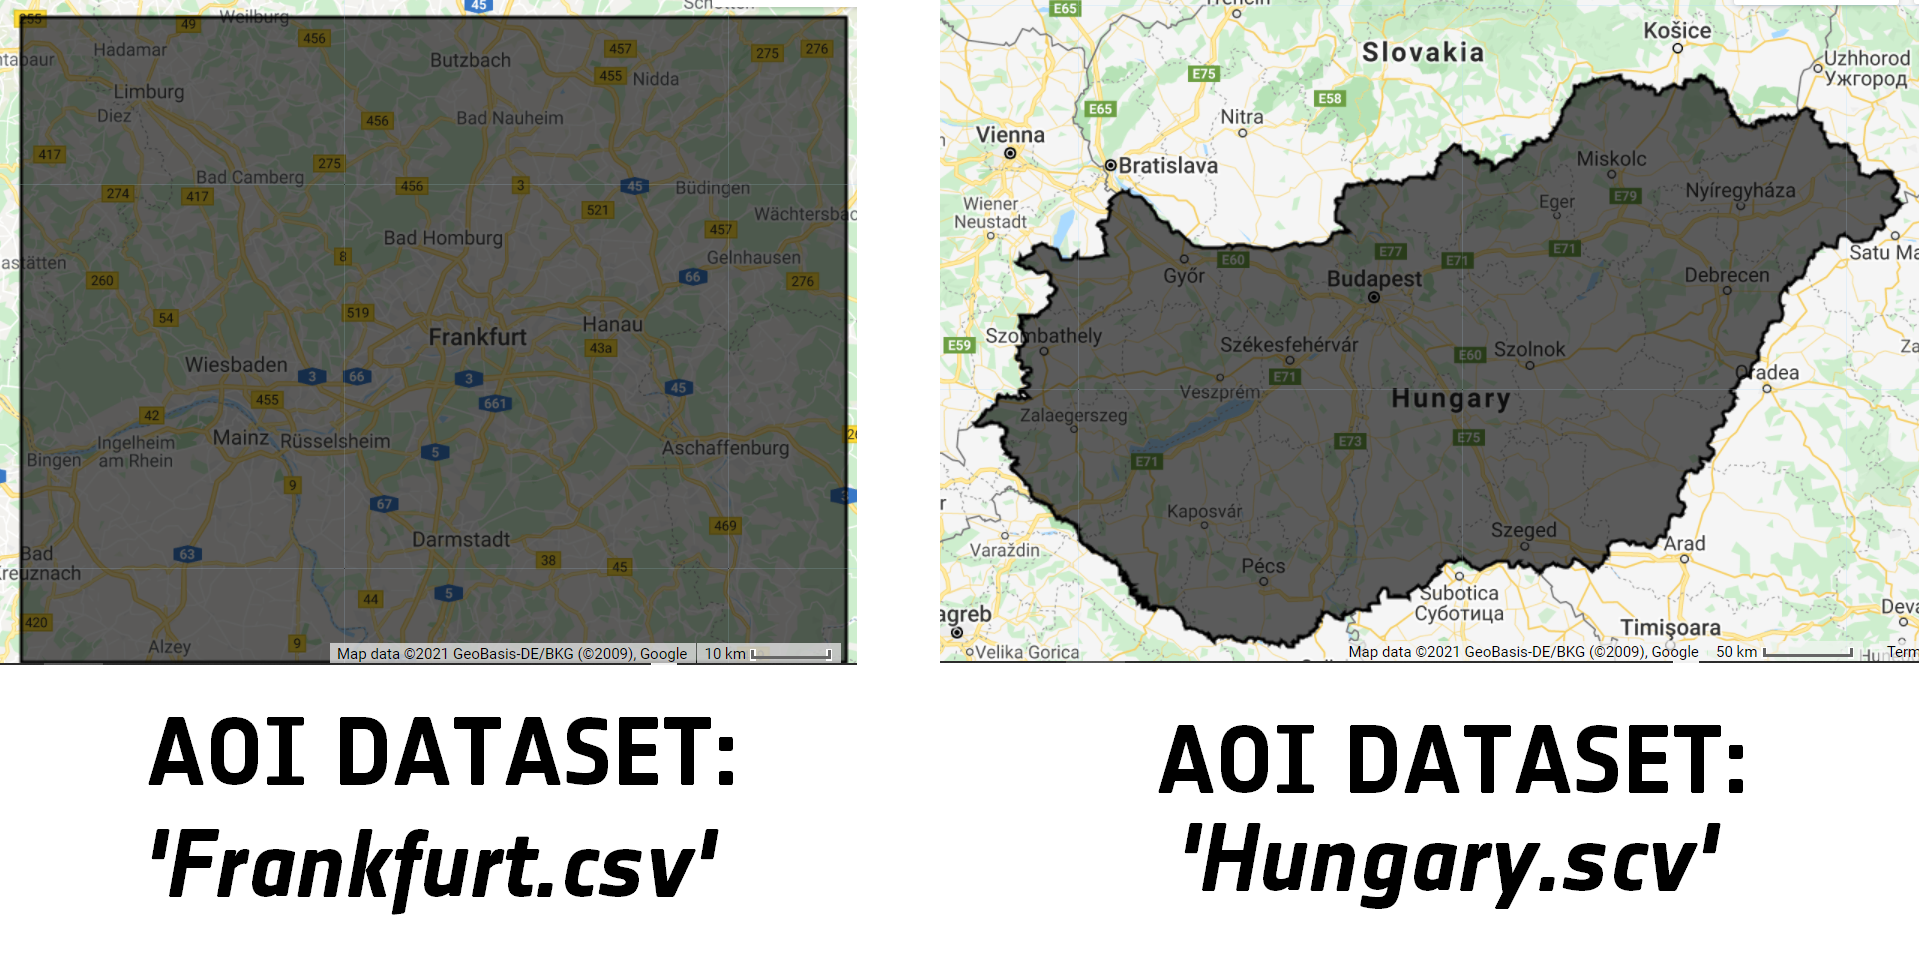

Source of dataset (CSV): created with a google earth engine script (which will be provided on last day of the course!)




In [4]:
path = '/home/jupyter-mleo/ml-for-eo/00 Exercises May 2023/Session1/Hungary.csv'

In [5]:
import pandas as pd

#create a dataframe with pd.read_csv(name_of_path) for Frankfurt dataset
df = pd.read_csv('/home/jupyter-mleo/ml-for-eo/00 Exercises May 2023/Session1/Hungary.csv')


In [6]:
# Print a list with the variables
print('variables', list(df))

# Visualize the first rows of your dataframe with head(3)
df.head()

variables ['NO2_column_number_density', 'O3_column_number_density', 'CO_column_number_density', 'H2O_column_number_density', 'SO2_column_number_density', 'tropospheric_HCHO_column_number_density', 'longitude', 'latitude']


,NO2_column_number_density,O3_column_number_density,CO_column_number_density,H2O_column_number_density,SO2_column_number_density,tropospheric_HCHO_column_number_density,longitude,latitude
0,0.000083,0.142031,0.034526,2533.188537,0.000065,0.000084,20.818457,48.576399
1,0.000083,0.142005,0.034556,2532.178387,0.000066,0.000085,20.845406,48.576399
2,0.000080,0.141441,0.035207,2509.955070,0.000084,0.000114,21.438294,48.576399
3,0.000084,0.142173,0.034294,2559.082394,0.000055,0.000075,20.629810,48.549450
4,0.000084,0.142147,0.034324,2557.818780,0.000056,0.000076,20.656760,48.549450


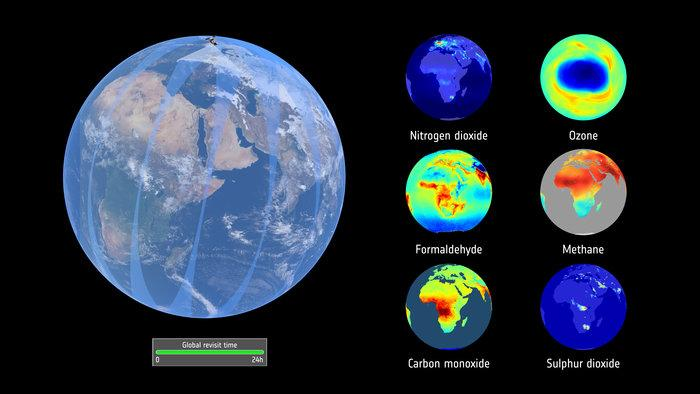

### Step1.1: Definition of features (X) and target (y) variables
Define features/predictors and labels/targets and covert data to arrays

- **features/predictors** **(X)** - what the model uses to make the predictions: **NO2 + H2O + etc...**
- **targets/labels** **(y)** - the value we want to predict: **O3**

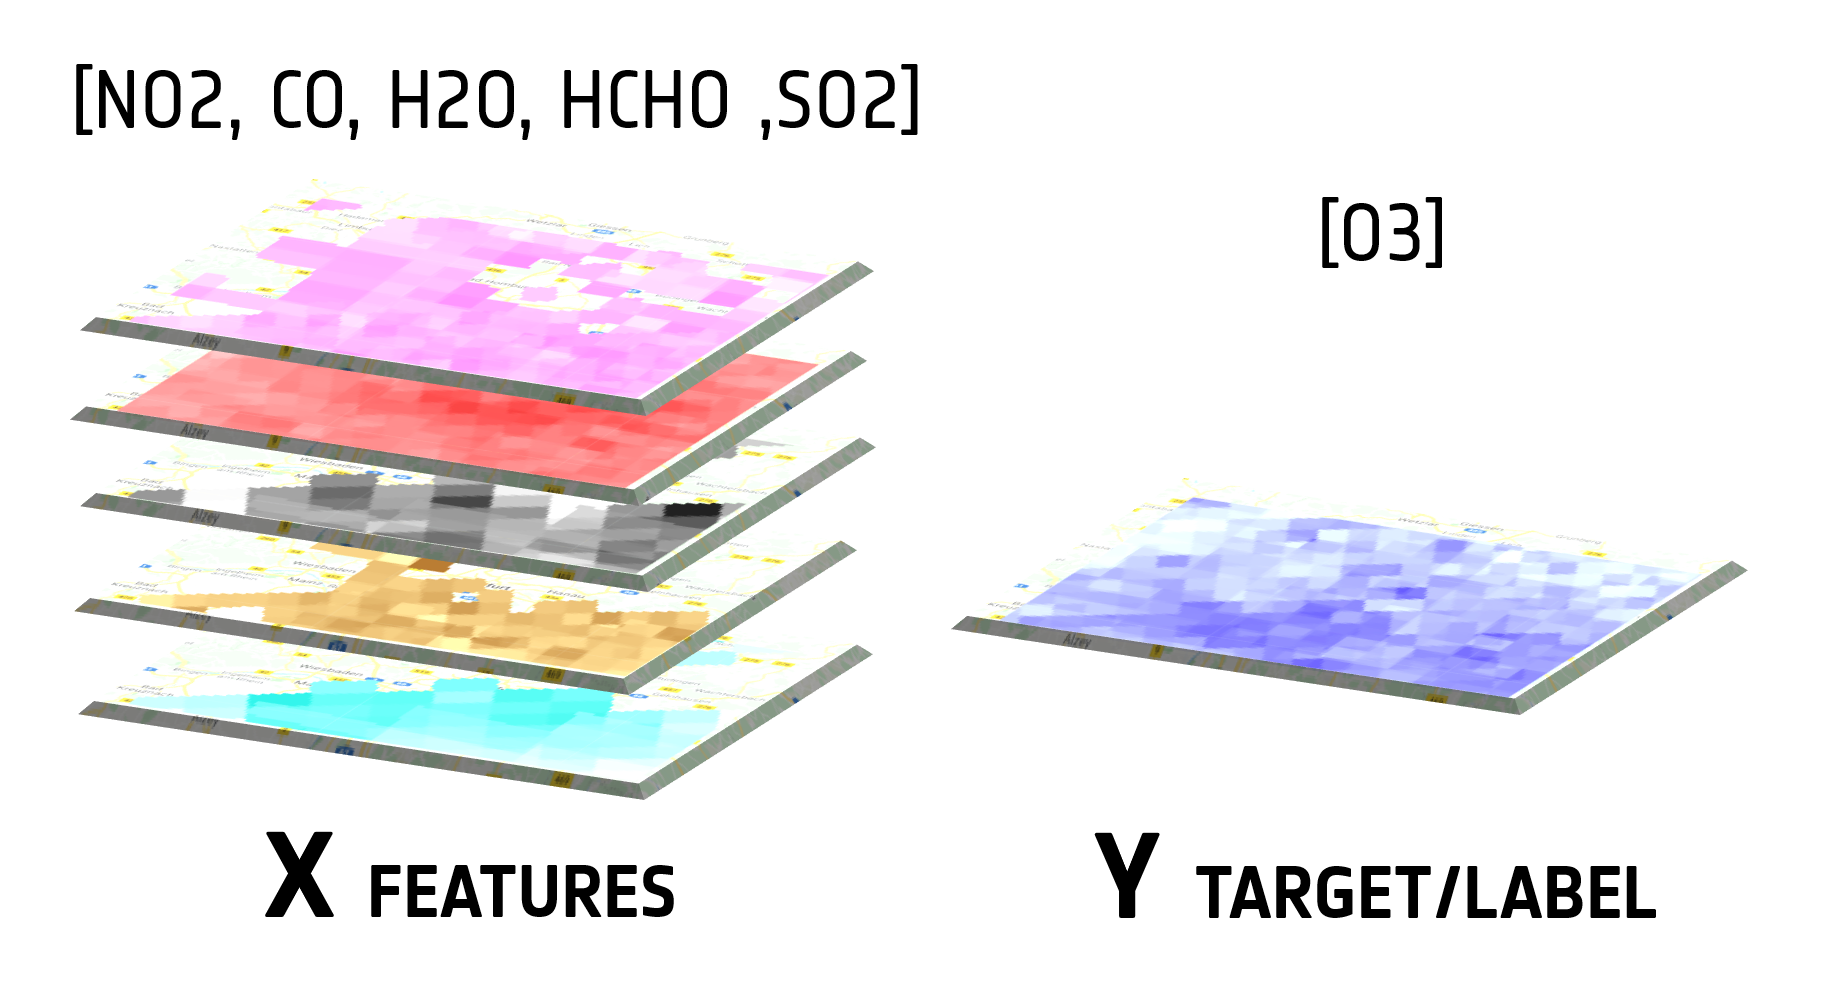


#### 1.1.1 Create an array with target/label data (y)

In [7]:
# Use numpy to convert to arrays
import numpy as np

# Create an array with a column of df called 'O3_column_number_density'
# This will be the values/label we want to predict
# First create select the column with >> df['name of varialbe']
# Then, convert it into an array with >> np.array()

y = np.array(df['O3_column_number_density'])
y

array([0.14203055, 0.14200493, 0.14144125, ..., 0.14035426, 0.14020317,
       0.14022798])

#### 1.1.2 Create an array with preditor/feature data (X)

In [8]:
# Remove features we don't want, axis 1 refers to the columns
X = df.drop([#'NO2_column_number_density', 
             'O3_column_number_density', 
             #'CO_column_number_density', 
             #'H2O_column_number_density', 
             #'SO2_column_number_density', 
             #'tropospheric_HCHO_column_number_density', 
             'longitude', 
             'latitude'], axis = 1)
# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
X =  np.array(X)
print('Variables for X will be:',feature_list)

Variables for X will be: ['NO2_column_number_density', 'CO_column_number_density', 'H2O_column_number_density', 'SO2_column_number_density', 'tropospheric_HCHO_column_number_density']


### Step1.2:  Training and Test data

The **train_test_split** allows to split arrays or matrices into random train and test subsets
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets 
# with train_test_split(name_of_features,name_of_labels, test_size=?,random_state = ?) 
# select a test size of 25% (0.25) and make sure your random_state is 42. 
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.10, random_state=42)

##### A mean step to ensure correct shapes features and labels:
We expect that:
- training features number of columns = testing feature number of columns 
-  number of rows to match for the respective training and testing features and the labels 

In [10]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)


Training Features Shape: (13680, 5)
Training Labels Shape: (13680,)
Testing Features Shape: (1520, 5)
Testing Labels Shape: (1520,)


### Step 2: Create the model
After all the work of data preparation, creating and training the model is pretty simple using Scikit-learn. 
We will start by importing the **random forest regression model** from skicit-learn, instantiate the model so that later we can fit the model (scikit-learn’s name for training) to training data. 

A **random forest** is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

- How to import other models...
- **from sklearn.ensemble import RandomForestRegressor** (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- You can visit https://scikit-learn.org/stable/index.html to find how to import other models

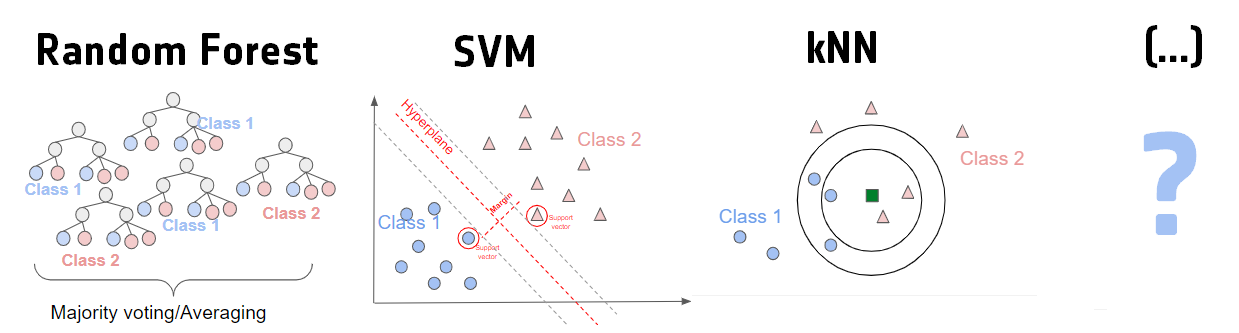

In [11]:
# Import the model we are going to use : RandomForestRegressor (find how using the link above)
from sklearn.ensemble import RandomForestRegressor 

# Instantiate model - choose the number of trees (n_estimator) as 100 and random_state to be 0.
model = RandomForestRegressor(n_estimators = 15, random_state=0)


### Step 3: Model fitting
 Fit the model, is the scikit-learn’s name for training the model on the training data. 

In [12]:
# Train the model with the training data with model.fit(name_of_features_trainig_data, name_of_labels_trainig_data)
# be aware of using training data and not the test data!
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=15, random_state=0)

### Step 4: Make predictions on the test data
Our model has now been trained to learn the relationships between the features and the targets. The next step is figuring out how good the model is! To do this we make predictions on the test features (the model is never allowed to see the test answers). 


In [13]:
# Make predictions on the test data with model.predict(name_of_features_test_data)
y_pred = model.predict(X_test)
#y_pred

### Step 5: Evaluate model's performance
We now compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value (as we also did when establishing the baseline).
Making predictions with out model is another 1-line command in Skicit-learn.
- For **regression** we use **R2 scor**e and **MAE**(mean absolute error)
- You can find here other metrics to evaluate regression (or classification models): https://scikit-learn.org/stable/modules/model_evaluation.html



In [14]:
#import the metrics r2_score (check out on the link shown above)
from sklearn.metrics import r2_score

In [15]:
# Print results
print('R2 score is:', r2_score(y_test, y_pred))

R2 score is: 0.9993059368813738


In [30]:
# MEA.....
from sklearn.metrics import mean_absolute_error
MEA = mean_absolute_error(y_test, y_pred)
print('MEA is:',MEA)
#RMSE.....
from sklearn.metrics import mean_squared_error
RSME =mean_squared_error(y_test,y_pred)
print('RSME is:',RSME)

MEA is: 1.7014790877764913e-05
RSME is: 1.350355484010429e-09


#### 5.1 Performing a k-fold cross validation

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train,y_train)
print("Cross-validation scores:", format(scores))

Cross-validation scores: [0.99857206 0.99805764 0.99917554 0.99881673 0.99864187]


#### ...Compute the mean

In [26]:
print("Average cross-validation score:",scores.mean())

Average cross-validation score: 0.9986527681982205


## Step 6: Go further! 

#### What happens if you keep the same model, same parameters, but a different (bigger) dataset?
#### What happens if you keep the same model, different parameters and same dataset?
#### What happens if choose a different model?

## Step 7/Optional: Revisiting Random Forests - Opening the box!

### What are the real world advantages and drawbacks of the Random Forest?
Random forests is an **ensemble of decision tree** algorithms.

RF is an extension of bootstrap aggregation (bagging) of decision trees and can be used for classification and regression problems.**Predictions** from the trees are **averaged** across all decision trees, resulting in better performance than any **single tree** in the model.

A prediction on a regression problem is the average of the prediction across the trees in the ensemble. A prediction on a classification problem is the majority vote for the class label across the trees in the ensemble.

When you train a RF model earlier it created **features_importances_** automatically. Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

<AxesSubplot:>

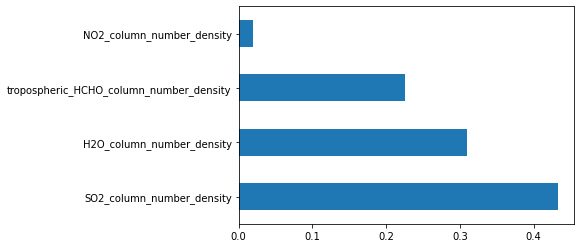

In [98]:
feat_importances = pd.Series(model.feature_importances_, index=feature_list)
feat_importances.nlargest(4).plot(kind='barh')

### Exporting the tree

Explore the sklearn website, for instance with **export_graphviz** from sklearn.tree you can export information as below.

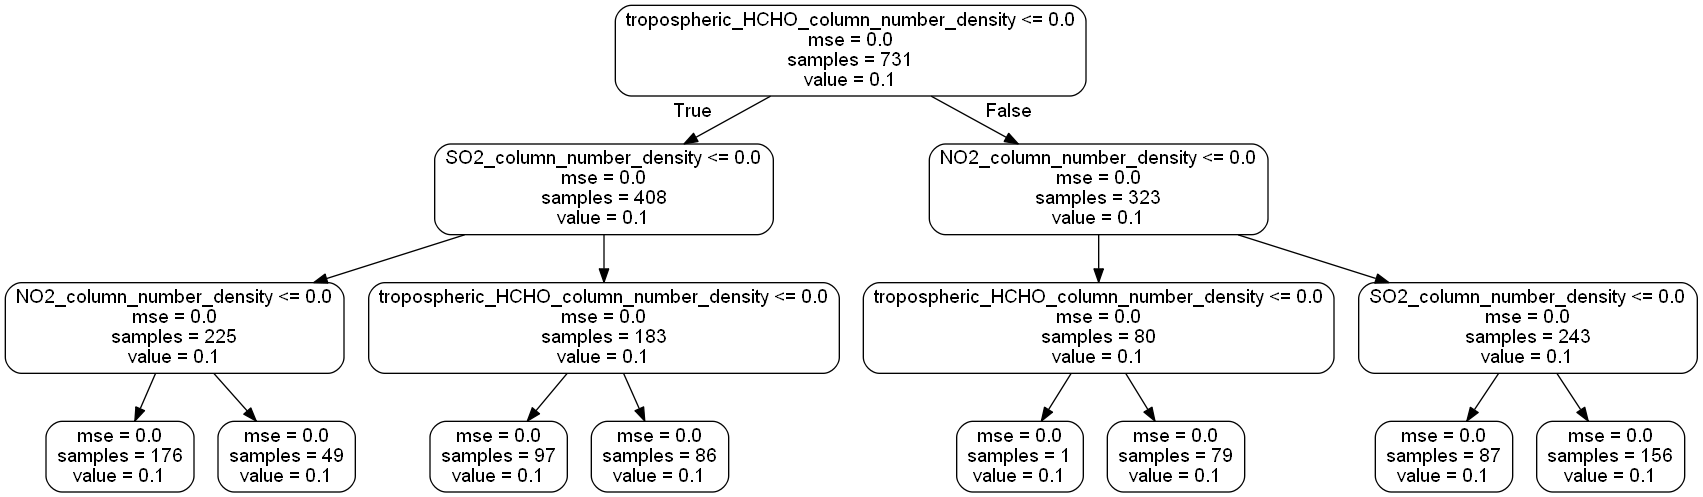